# Appear Here Test
Goal : Answer to the two parts of appear here take home test
- part 1 : REDSHIFT SQL only writting to answer the three questions
- part 2 : ML solutions to improve booking patterns of appear here clients

Author : Pauline Guilmin

Created: **24/01/19**
Modifié le : **25/01/19**


Données utilisées : 
- ideas.csv: 
    - creation date 
    - space category
    - id
- transitions.csv
    - transition time
    - booking id
    - informations about space (id, city, country, category, floor_size, ...)
    - information about booking proposition (price, check-in,check-out, state ...)

Etapes utilisées :
- PART I : SQL 
    - 1st question
    - 2nd question
    - 3d question
- PART 2 : ML 
- import librairies
- charge datasets : 
    - import 
    - cleaning and add features
    - sort and drop duplicates
- explore **ideas**
- explore **transitions**
    - add some features : to_state_af, to_state_bf, capital, time_booked
- merge ideas and transitions : explore **total**
    - add features : time_to_booking, time_to_check_in
- suppress ideas without transitions : explore **total_ok**
- create table **conversion** 
    - pattern for each booking id
    - pattern for each new submission (submitted state)
- create table for MCA on R **booking_acm**
- ML table **booking_ml**
    - adapt features and create new 
    - correlation between features
    - deal with imbalanced data
    - Random forest 
    - Logistic regression


# import libraries

In [73]:
import numpy as np 
import pandas as pd
pd.options.display.max_colwidth = 500
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [6]:
!pwd

/Users/paguilmin/Documents/AppearHere_Test/analysis


# Charge datasets

## import csv

In [7]:
path = '../data/'
ideas = pd.read_csv(path+'ideas.csv',sep=',')
transitions = pd.read_csv(path+'transitions.csv',sep=',')

## cleaning

### supress first column unuseful

In [8]:
ideas = ideas.drop(['Unnamed: 0'],axis=1)
transitions.columns
transitions = transitions.drop(['Unnamed: 0'],axis=1)

In [9]:
# some dates are not well written : 0019 instead of 2019 and 0020 instead of 2020
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'] = \
transitions.loc[transitions['start_on'].str.startswith('2')==False,'start_on'].str.replace('0019','2019')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0020','2020')
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'] = \
transitions.loc[transitions['end_on'].str.startswith('2')==False,'end_on'].str.replace('0019','2019')

### manage datetimes

In [10]:
###TRANSITIONS###
#time of booking
transitions.loc[:,'transition_ts'] = pd.to_datetime(transitions.loc[:,'transition_ts'])
transitions.loc[:,'transition_ts_year'] = transitions.loc[:,'transition_ts'].dt.year
transitions.loc[:,'transition_ts_mth'] = transitions.loc[:,'transition_ts'].dt.month

#check-in 
transitions.loc[:,'start_on'] = pd.to_datetime(transitions.loc[:,'start_on'])
transitions.loc[:,'start_on_year'] = transitions.loc[:,'start_on'].dt.year
transitions.loc[:,'start_on_mth'] = transitions.loc[:,'start_on'].dt.month

#check-out
transitions.loc[:,'end_on'] = pd.to_datetime(transitions.loc[:,'end_on'])
transitions.loc[:,'end_on_year'] = transitions.loc[:,'start_on'].dt.year
transitions.loc[:,'end_on_month'] = transitions.loc[:,'start_on'].dt.month

# time-booking
transitions['time_booked'] = transitions.loc[:,'end_on']- transitions.loc[:,'start_on']
transitions.loc[:,'time_booked'] = transitions.loc[:,'time_booked']/ np.timedelta64(1, 'D')

In [ ]:
###IDEAS###
#time of creation
ideas.loc[:,'created_at'] = pd.to_datetime(ideas.loc[:,'created_at'])
ideas.loc[:,'created_at'] = ideas.loc[:,'created_at'].dt.year
ideas.loc[:,'created_at'] = ideas.loc[:,'created_at'].dt.year

In [ ]:
### add columns

In [ ]:
# state before 
transitions['to_state_bf']= transitions['to_state'].shift(1)
# state after : unuseful 
transitions['to_state_af']= transitions['to_state'].shift(-1)

## sort and drop duplicates

In [11]:
transitions = transitions.sort_values(['idea_id','space_id','transition_ts'])
print('transitions : Nb records before drop_duplicates %0.0f :' %(transitions.shape[0]))
transitions = transitions.drop_duplicates()
print('transitions :Nb records before drop_duplicates %0.0f :' %(transitions.shape[0]))

print('ideas : Nb records before drop_duplicates %0.0f :' %(ideas.shape[0]))
ideas = ideas.drop_duplicates()
print('ideas : Nb records before drop_duplicates %0.0f :' %(ideas.shape[0]))

# useful fonctions

In [12]:
def top_champ(df,feature,number) :
    df_ok = df.copy()
    df_ok[feature] = df_ok[feature].fillna('unknown')
    top_10 = df_ok.groupby(feature).agg('size').sort_values(ascending=False).to_frame().reset_index()
    top_10.columns=[str(x) for x in feature]+['nb_records']
    top_10['percentage']=(100.* (top_10['nb_records'] / top_10['nb_records'].sum())).round(2)
    print('%0.0f distinct values for the feature %s' %(top_10.shape[0],feature))
    return top_10.head(number)

# ideas exploration

## structure

In [13]:
print('ideas csv contains %0.0f rows and %0.0f columns' %(ideas.shape[0],ideas.shape[1]))
ideas.nunique()

ideas csv contains 4000 rows and 3 columns


created_at    4000
category         6
idea_id       4000
dtype: int64

## explore some features

### space category

In [14]:
top_champ(ideas,['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,2174,54.35
1,private_event,546,13.65
2,popup_bar,533,13.32
3,unique,398,9.95
4,gallery,282,7.05
5,sample_sale,67,1.68


### creation times

In [ ]:
min_created = min(ideas['created_at'])
max_created = max(ideas['created_at'])
print('Ideas have been created from %s to %s' %(min_created, max_created))

# transitions exploration

## structure

In [16]:
print('transitions csv contains %0.0f rows and %0.0f columns' %(transitions.shape[0],transitions.shape[1]))
transitions.nunique()

transitions csv contains 21062 rows and 14 columns


transition_ts         21062
category                  6
idea_id                2677
booking_request_id     9942
to_state                  4
space_id               2065
country                   3
city                    110
portfolio_type            9
floor_size              548
floor_size_unit           2
start_on                503
end_on                  618
price                  3593
dtype: int64

## explore some features

### time_booked

In [79]:
print(transitions['time_booked'].describe())
print('\n0 days booked seem to be an error')
#id_bk_notime = transitions.loc[transitions['time_booked']==0,'booking_request_id'].unique()

count    20475.000000
mean        41.669402
std        174.985036
min          0.000000
25%          1.000000
50%          6.000000
75%         22.000000
max       8115.000000
Name: time_booked, dtype: float64

0 days booked seem to be an error


### to_state

#### ideas ended by a booking

In [83]:
states_ideas = transitions.groupby(['idea_id','to_state']).agg('size').to_frame().reset_index()
idea_id_booked = states_ideas.loc[states_ideas['to_state']=='booked','idea_id'].unique()
print('Above 4000 ideas %0.0f ideas have been booked at least one time' %len(idea_id_booked))
#states_ideas[states_ideas['idea_id'].isin(idea_id_booked)]
#I could have calculate it more simply but I wanted to explore other informations when I wrote that

Above 4000 ideas 302 ideas have been booked at least one time


#### to_state_af

In [20]:
top_champ(transitions[transitions['to_state']=='matched'],['to_state_af'],10)

4 distinct values for the feature ['to_state_af']


,to_state_af,nb_records,percentage
0,declined,2125,78.88
1,booked,388,14.40
2,submitted,117,4.34
3,matched,64,2.38


#### to_state_bf

In [84]:
print(top_champ(transitions[transitions['to_state']=='booked'],['to_state_bf'],10))
transitions.loc[(transitions['to_state']=='booked') &
           (transitions['to_state_bf']=='declined'),'idea_id'].unique()

4 distinct values for the feature ['to_state_bf']
  to_state_bf  nb_records  percentage
0     matched         334       89.07
1    declined          25        6.67
2      booked          10        2.67
3   submitted           6        1.60


array([ 230,  245,  323,  430,  449,  451,  834,  902,  917, 1094, 1335,
       1535, 1698, 1794, 1919, 2161, 2214, 2846, 3034, 3183, 3329, 3510,
       3791, 3861, 3926])

## floor size

Floor size unit : 0
count    14682.000000
mean      1533.663193
std       2999.905902
min         20.000000
25%        333.000000
50%        800.000000
75%       1780.000000
max      50000.000000
Name: floor_size, dtype: float64
Floor size unit : 1

count    5793.000000
mean      109.032971
std       218.851472
min         2.000000
25%        33.000000
50%        55.000000
75%       110.000000
max      4700.000000
Name: floor_size, dtype: float64

Boxplot depending floor size unit

It seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2


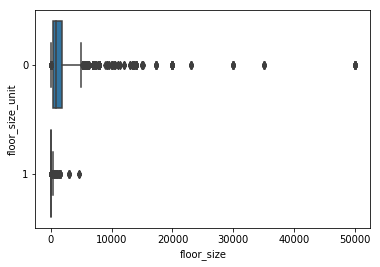

In [100]:
# Let's check the difference between floor size unit 0 and 1 
print('Floor size unit : 0')
print(transitions.loc[transitions['floor_size_unit']==0,'floor_size'].describe())
print('Floor size unit : 1\n')
print(transitions.loc[transitions['floor_size_unit']==1,'floor_size'].describe())

print('\nBoxplot depending floor size unit')
sns.boxplot(x=transitions.floor_size, y=transitions.floor_size_unit,orient="h")
print('\nIt seems to be 0 for sq feets and 1 for sq meters as  : 1 feet^2 = 0.09 m^2')

In [24]:
#verification ok 
transitions.groupby(['country','floor_size_unit']).agg('size')

country  floor_size_unit
FR       1                   5787
GB       0                  11664
         1                      6
US       0                   3605
dtype: int64

In [25]:
# put all in sq meters 
transitions.loc[:,'floor_size_m']=transitions.loc[:,'floor_size']
print(transitions.loc[:,'floor_size_m'].describe())
transitions.loc[transitions['floor_size_unit']==0,'floor_size_m']=round(transitions.loc[:,'floor_size_m']*0.09)
print(transitions.loc[:,'floor_size_m'].describe())
#anomaly sq meters below 1 
transitions = transitions.loc[transitions['floor_size_m']>1]

count    21062.000000
mean      1100.891321
std       2592.375283
min          1.000000
25%         65.000000
50%        400.000000
75%       1175.000000
max      50000.000000
Name: floor_size_m, dtype: float64
count    21062.000000
mean       126.362928
std        254.152606
min          0.000000
25%         29.000000
50%         63.000000
75%        140.000000
max       4700.000000
Name: floor_size_m, dtype: float64


In [26]:
transitions.loc[transitions['floor_size_m']>   200,'floor_size_cat'] = 'sup_200'
transitions.loc[transitions['floor_size_m']<=  200,'floor_size_cat'] = '100_200'
transitions.loc[transitions['floor_size_m']<   100,'floor_size_cat'] = '80_100'
transitions.loc[transitions['floor_size_m']<    80,'floor_size_cat'] = '60_80'
transitions.loc[transitions['floor_size_m']<    60,'floor_size_cat'] = '40_60'
transitions.loc[transitions['floor_size_m']<    40,'floor_size_cat'] = '20_40'
transitions.loc[transitions['floor_size_m']<    20,'floor_size_cat'] = 'inf_20'

In [27]:
top_champ(transitions,['floor_size_cat'],10)

7 distinct values for the feature ['floor_size_cat']


,floor_size_cat,nb_records,percentage
0,100_200,3711,18.11
1,20_40,3659,17.86
2,sup_200,3256,15.89
3,40_60,3049,14.88
4,inf_20,2814,13.73
5,60_80,2156,10.52
6,80_100,1847,9.01


## prices

different prices for each space which means : each price depends also from other parameters such as       the time booked and floor size
There is not linear regression : price must depend from multilinear combination and from other parameters


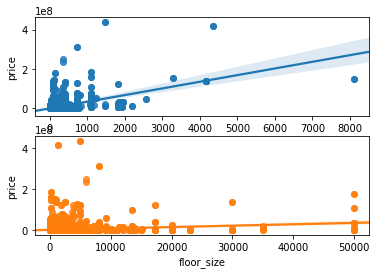

In [88]:
transitions.groupby(['space_id','price']).agg('size').to_frame().reset_index()
print('different prices for each space which means : each price depends also from other parameters such as \
      the time booked and floor size')
fig, (ax1, ax2) = plt.subplots(2, 1)
sns.regplot(x='time_booked', y="price", data=transitions,ax=ax1)
sns.regplot(x='floor_size', y="price", data=transitions,ax=ax2)
print('There is not linear regression : price must depend from multilinear combination and from other parameters')

count    2.047500e+04
mean     1.859839e+06
std      1.059067e+07
min      1.000000e+02
25%      9.000000e+04
50%      2.800000e+05
75%      9.137500e+05
max      4.386000e+08
Name: price, dtype: float64
There is a lot of outliers


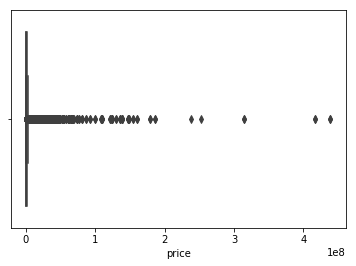

In [101]:
# price distribution
print(transitions.price.describe())
sns.boxplot(x=transitions.price,whis=[10,90])
print('There is a lot of outliers, even showing percentiles instead of quartiles')
#anomaly price equals 0
transitions = transitions[transitions['price']!=0]

In [102]:
#price categories
transitions.loc[transitions['price']>   5000000,'price_category'] = 'sup_5millions'
transitions.loc[transitions['price']<=  5000000,'price_category'] = '1_5millions'
transitions.loc[transitions['price']<   1000000,'price_category'] = '500k_1millions'
transitions.loc[transitions['price']<    500000,'price_category'] = '200k_500k'
transitions.loc[transitions['price']<    300000,'price_category'] = '100k_200k'
transitions.loc[transitions['price']<    100000,'price_category'] = '50k_100k'
transitions.loc[transitions['price']<     50000,'price_category'] = '10k_50k'
transitions.loc[transitions['price']<     10000,'price_category'] = 'inf_10k'

top_champ(transitions,['price_category'],10)

8 distinct values for the feature ['price_category']


,price_category,nb_records,percentage
0,100k_200k,5085,24.84
1,1_5millions,3685,18.00
2,500k_1millions,2674,13.06
3,10k_50k,2651,12.95
4,200k_500k,2365,11.55
5,50k_100k,2253,11.00
6,sup_5millions,1230,6.01
7,inf_10k,532,2.60


## city

### supress punctuation

In [31]:
import re
transitions.loc[:,'city_ok'] = transitions.loc[:,'city']\
.apply(lambda x : re.sub("\W", " ",x))

### gather capital names

In [32]:
transitions.loc[:,'city_ok'] = transitions.loc[:,'city_ok'].str.lower().str.strip()

transitions.loc[transitions['city_ok']\
               .isin(['new york','nyc','new york city']),'city_ok']\
                     = 'new york'
transitions.loc[transitions['city_ok']\
               .str.startswith('paris'),'city_ok']\
                     = 'paris'

### add a boolean feature : capital

In [34]:
top_champ(transitions,['country'],100)

3 distinct values for the feature ['country']


,country,nb_records,percentage
0,GB,11085,54.14
1,FR,5787,28.26
2,US,3603,17.60


In [33]:
transitions.loc[:,'capital']= 0
transitions.loc[transitions['city_ok']\
               .isin(['paris','new york','london']),'capitale']\
                     = 1

## some booking examples

In [22]:
#transitions[transitions['space_id']==6735]
#transitions[transitions['idea_id']==105]

# total exploration

## merge ideas and transitions

In [35]:
total = pd.merge(ideas, transitions, how='left', left_on='idea_id',right_on='idea_id')

## add features

In [36]:
# time between idea creation and first request
total.loc[:,'time_to_request'] = total.loc[:,'transition_ts']- total.loc[:,'created_at']
total.loc[:,'time_to_request'] = total.loc[:,'time_to_request']/ np.timedelta64(1, 'D')
# time between idea creation and check-in : planification time
total.loc[:,'time_to_check_in'] = total.loc[:,'start_on']- total.loc[:,'created_at']
total.loc[:,'time_to_check_in'] = total.loc[:,'time_to_check_in']/ np.timedelta64(1, 'D')


4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,2324,58.10
1,unknown,1379,34.48
2,declined,296,7.40
3,booked,1,0.02


## explore to_state

In [ ]:
# first state 
total_first = total.drop_duplicates('idea_id')
top_champ(total_first,['to_state'],10)

## explore time_after_creation

In [105]:
print(total_first.loc[:,'time_after_creation'].describe())

count    2.621000e+03
mean     8.166390e+00
std      2.840558e+01
min      6.250000e-07
25%      1.099537e-06
50%      2.129630e-06
75%      1.106576e+00
max      3.370219e+02
Name: time_after_creation, dtype: float64


## explore category evolution

In [103]:
# booking lines with evolution of category feature (between idea and booking requests)
print('nb of records with evolution of category feature : %0.Of' %total[total['category_x']!=total['category_y']].shape[0])
# booking lines with no booking requests
print('nb of records with no booking request : %0.Of' %total[total['category_y'].isnull()].shape[0])
# nb of ideas without bookings requests
idea_id_unknown = total.loc[total['category_y'].isnull(),'idea_id'].unique()
print('nb of ideas without bookings requests %0.0f' %len(idea_id_unknown))

1379
1379
1379


### ideas without booking requests

In [38]:
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_unknown),'created_at'])
print('There are %0.0f ideas unknown' %len(idea_id_unknown))
print('Ideas unknown have been created from %s to %s' %(min_created_ukn, max_created_ukn))

There are 1379 ideas unknown
Ideas unknown have been created from 2018-01-01 17:01:01.489000 to 2019-01-21 10:19:35.205000
There are 2621 ideas with at least one request submitted
Ideas with requests have been created from 2018-01-02 15:21:32.044000 to 2019-01-15 14:54:49.719000


In [39]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_unknown)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,760,55.11
1,popup_bar,240,17.40
2,unique,145,10.51
3,private_event,134,9.72
4,gallery,78,5.66
5,sample_sale,22,1.60


### ideas with booking requests

In [ ]:
idea_id_known = total.loc[total['category_y'].notnull(),'idea_id'].unique()
min_created_ukn = min(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
max_created_ukn = max(ideas.loc[ideas['idea_id'].isin(idea_id_known),'created_at'])
print('There are %0.0f ideas with at least one request submitted' %(len(idea_id_known)))
print('Ideas with requests have been created from %s to %s' %(min_created_ukn, max_created_ukn))

In [40]:
top_champ(ideas[ideas['idea_id'].isin(idea_id_known)],['category'],10)

6 distinct values for the feature ['category']


,category,nb_records,percentage
0,popup_shop,1414,53.95
1,private_event,412,15.72
2,popup_bar,293,11.18
3,unique,253,9.65
4,gallery,204,7.78
5,sample_sale,45,1.72


## supress idea without booking requests

We don't have enough informations about ideas without booking requests to make interpretation about it
It could also be because : booking requests for those ideas are not in this transition dataset but in the real database

In [104]:
total_ok = total.loc[total['idea_id'].isin(idea_id_known)]

# total_ok exploration

## time_after_creation

In [42]:
total_ok['time_after_creation'].describe()

count    2.047500e+04
mean     2.350080e+01
std      4.889505e+01
min      6.250000e-07
25%      1.153481e-01
50%      4.062131e+00
75%      2.003718e+01
max      3.599833e+02
Name: time_after_creation, dtype: float64

### time after creation categories

In [106]:
total_ok.loc[total_ok['time_after_creation']>15,'after_creation'] = 'sup_15j'
total_ok.loc[total_ok['time_after_creation']<=15,'after_creation'] = '3j_15j'
total_ok.loc[total_ok['time_after_creation']<3,'after_creation'] = '1j_3j'
total_ok.loc[total_ok['time_after_creation']<1,'after_creation'] = '1h_1j'
total_ok.loc[total_ok['time_after_creation']<0.04,'after_creation'] = '10s_1h'
total_ok.loc[total_ok['time_after_creation']<0.0001,'after_creation'] = 'less_10s'

/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda/envs/ah_test_env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
top_champ(total_ok.drop_duplicates('idea_id'),['after_creation'],10)
# More than an half of the ideas transforms in a request in less than 10 seconds

6 distinct values for the feature ['after_creation']


,after_creation,nb_records,percentage
0,less_10s,1521,58.03
1,sup_15j,282,10.76
2,3j_15j,274,10.45
3,10s_1h,231,8.81
4,1h_1j,200,7.63
5,1j_3j,113,4.31


# conversion table

Creation of tables showing the different patterns between the first request and the booking or declination of a request

In [52]:
print(transitions.drop_duplicates(['booking_request_id','city','space_id']).shape)
transitions.drop_duplicates(['booking_request_id']).shape

(9676, 22)


(9676, 22)

## pattern for each booking_id (1space for 1 particular idea)

In [46]:

conversion = total_ok.groupby(['idea_id','space_id','booking_request_id'])['to_state'].\
apply(lambda x: "%s" % ' / '.join(x)).to_frame().reset_index()
#conversion
#top_champ(conversion,['to_state'],10)
conversion.loc[:,'ending_stage'] = conversion.loc[:,'to_state'].apply(lambda x : x.split(' ')[-1])



In [109]:
top_champ(conversion,['idea_id','ending_stage'],5)\
.sort_values(['ending_stage','nb_records'],ascending=True)
#conversion

2998 distinct values for the feature ['idea_id', 'ending_stage']


,idea_id,ending_stage,nb_records,percentage
3,2988,declined,38,0.39
4,1229,declined,38,0.39
2,2364,declined,45,0.47
1,1255,declined,48,0.50
0,3650,declined,156,1.61


In [49]:
top_champ(conversion[conversion.ending_stage=='submitted'],['to_state'],100)

4 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted,303,95.58
1,submitted / submitted,8,2.52
2,submitted / declined / submitted,5,1.58
3,submitted / submitted / submitted,1,0.32


## new pattern each time there is a submission

In [ ]:
conversion_2 = conversion\
.join(conversion['to_state'].str.split(' / s', expand=True)\
      .stack().reset_index(level=1, drop=True).rename('to_state_2'))
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ubmitted','submitted')
conversion_2.loc[:,'to_state_2'] = conversion_2['to_state_2'].str.replace('ssubmitted','submitted')
conversion_2.loc[:,'ending_stage_2'] = conversion_2.loc[:,'to_state_2'].apply(lambda x : x.split(' ')[-1])



In [110]:
top_champ(conversion_2,['to_state'],5)

59 distinct values for the feature ['to_state']


,to_state,nb_records,percentage
0,submitted / declined,4780,47.07
1,declined,1827,17.99
2,submitted / matched / declined,1753,17.26
3,submitted,303,2.98
4,submitted / matched / booked,297,2.92


In [53]:
test = total_ok[(total_ok['booking_request_id']==114598.0)]
test.iloc[:,10:20]\
#[['created_at','transition_ts','booking_request_id','space_id','to_state','start_on','end_on','time_booked']]

,portfolio_type,floor_size,floor_size_unit,start_on,end_on,price,to_state_bf,to_state_af,time_booked,floor_size_m
230,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,declined,declined,6.0,90.0
231,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,submitted,submitted,6.0,90.0
232,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,declined,declined,6.0,90.0
233,3.0,1000.0,0.0,2018-06-11,2018-06-17,500000.0,submitted,declined,6.0,90.0


# MCA on R bookings ok

To make an MCA we need "factor" features which means categories.        
Hence, we only keep features with categories     
**Goal** : explore the relations between features and once the new reduced axis are created, projection of the feature to predict "ending_stage"

In [55]:
bookings_mca = pd.merge(conversion[['booking_request_id','to_state','ending_stage']],
                      total_ok.drop_duplicates('booking_request_id')\
                       [['booking_request_id',
                         'country', 'city','city_ok','capitale',
                         'portfolio_type', 'floor_size_cat','price_category',
                         'time_booked', 'time_after_creation', 'after_creation']],\
                       how='inner', on = 'booking_request_id')

In [56]:
# reservation more than 1 day (without bug)
bookings_mca =bookings_mca[bookings_mca['time_booked']>0]

In [57]:
bookings_mca['time_booked'].describe()

count    7841.000000
mean       54.971815
std       192.477730
min         1.000000
25%         4.000000
50%         8.000000
75%        30.000000
max      8115.000000
Name: time_booked, dtype: float64

In [58]:
bookings_mca.loc[bookings_mca['time_booked']> 30,'times_booked_cat'] = 'sup_30'
bookings_mca.loc[bookings_mca['time_booked']<=30,'times_booked_cat'] = '15_30'
bookings_mca.loc[bookings_mca['time_booked']< 15,'times_booked_cat'] = '10_15'
bookings_mca.loc[bookings_mca['time_booked']< 10,'times_booked_cat'] = '7_10'
bookings_mca.loc[bookings_mca['time_booked']< 7,'times_booked_cat'] = '5_7'
bookings_mca.loc[bookings_mca['time_booked']< 5,'times_booked_cat'] = '3_5'
bookings_mca.loc[bookings_mca['time_booked']< 3,'times_booked_cat'] = 'inf_3'

In [59]:
top_champ(bookings_mca,['times_booked_cat'],100)

7 distinct values for the feature ['times_booked_cat']


,times_booked_cat,nb_records,percentage
0,sup_30,1699,21.67
1,inf_3,1548,19.74
2,5_7,1269,16.18
3,15_30,1139,14.53
4,10_15,867,11.06
5,3_5,671,8.56
6,7_10,648,8.26


In [654]:
bookings_mca.to_csv('bookings_ok.csv') 

In [526]:
# finished bookings : either declined or booking
bookings_mca = bookings_mca[bookings_mca['ending_stage'].isin(['declined','booked'])]

In [527]:
top_champ(bookings_mca,['ending_stage'],100)

2 distinct values for the feature ['ending_stage']


,ending_stage,nb_records,percentage
0,declined,7354,95.79
1,booked,323,4.21


In [529]:
bookings_mca.columns

Index(['booking_request_id', 'to_state', 'ending_stage', 'idea_id', 'space_id',
       'country', 'city', 'portfolio_type', 'floor_size', 'floor_size_unit',
       'time_booked', 'price', 'time_after_creation', 'after_creation'],
      dtype='object')

# ML 

## Create bookings_ml

In [ ]:
###

In [63]:
total_ok.columns

Index(['created_at', 'category_x', 'idea_id', 'transition_ts', 'category_y',
       'booking_request_id', 'to_state', 'space_id', 'country', 'city',
       'portfolio_type', 'floor_size', 'floor_size_unit', 'start_on', 'end_on',
       'price', 'to_state_bf', 'to_state_af', 'time_booked', 'floor_size_m',
       'floor_size_cat', 'price_category', 'city_ok', 'capitale',
       'time_after_creation', 'after_creation'],
      dtype='object')

Text(0.5, 1.0, 'Represents the correlations betweeen features')

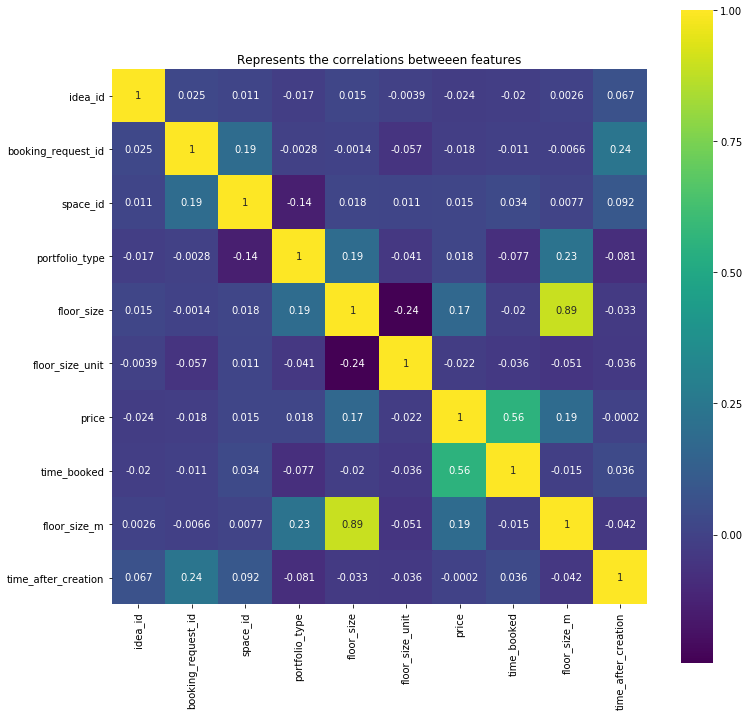

In [111]:
tab_corr = total_ok.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(tab_corr, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Represents the correlations betweeen features')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
X = bookings.iloc[:,0:4].values
y = df.iloc[:,4].values